In [1]:
import numpy as np
import pandas as pd
import os
import glob
import itertools
import scanpy as sc
import natsort
import json

from scroutines import basicu

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%%time
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/superdupermegaRNA_hasraw_cheng22_l23.h5ad'
fout = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/scores_l23abc_cheng22_250904.csv'

adata_all = sc.read(f)
genes_mul = adata_all.var.index.values
adata_all

CPU times: user 952 ms, sys: 3.13 s, total: 4.08 s
Wall time: 22.1 s


AnnData object with n_obs × n_vars = 40669 × 16572
    obs: 'Age', 'Doublet', 'Doublet Score', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'Type', 'Subclass', 'Class', 'Sample', 'total_counts', 'pct_counts_mt', 'n_genes_by_counts', 'total_counts_mt', 'Doublet?', 'Study', 'Type_leiden'
    var: 'feature_types'

In [3]:
unq_samples = natsort.natsorted(adata_all.obs['Sample'].unique())
print(len(unq_samples))
print(unq_samples) 

unq_conds   = natsort.natsorted(adata_all.obs['Age'].unique())
nf = len(unq_conds)
print(nf)
print(unq_conds)

35
['P8_1a', 'P8_1b', 'P8_2a', 'P8_2b', 'P14_1a', 'P14_1b', 'P14_2a', 'P14_2b', 'P17_1a', 'P17_1b', 'P17_2a', 'P17_2b', 'P21_1a', 'P21_1b', 'P21_2a', 'P21_2b', 'P28_1a', 'P28_1b', 'P28_2a', 'P28_2b', 'P28_dl_1a', 'P28_dl_1b', 'P28_dl_2a', 'P28_dl_2b', 'P28_dr_1a', 'P28_dr_1b', 'P28_dr_3a', 'P28_dr_3b', 'P38_1a', 'P38_2a', 'P38_2b', 'P38_dr_1a', 'P38_dr_1b', 'P38_dr_2a', 'P38_dr_2b']
9
['P8', 'P14', 'P17', 'P21', 'P28', 'P28_dl', 'P28_dr', 'P38', 'P38_dr']


In [4]:
# 
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/cheng21_cell_scrna/res/L23-ABC-genes-n288-n286unq-annot_v3_july8_2024.csv'
anno = pd.read_csv(f)
agenes = anno.loc[anno['P17on']=='A', 'gene'].values
bgenes = anno.loc[anno['P17on']=='B', 'gene'].values
cgenes = anno.loc[anno['P17on']=='C', 'gene'].values
print(agenes.shape, bgenes.shape, cgenes.shape)

agenes = np.intersect1d(agenes, genes_mul)
bgenes = np.intersect1d(bgenes, genes_mul)
cgenes = np.intersect1d(cgenes, genes_mul)
print(agenes.shape, bgenes.shape, cgenes.shape)

(122,) (35,) (129,)
(118,) (34,) (126,)


In [5]:
x = adata_all.raw.X
cov = np.array(x.sum(axis=1)).reshape(-1,)
xln = np.log2(1 + np.array(x.todense()) / cov.reshape(-1,1) * 1e4)
xln

array([[4.0318675, 1.1252114, 0.       , ..., 0.       , 3.3855247,
        1.1252114],
       [2.9495256, 0.       , 0.       , ..., 1.6967282, 2.9495256,
        0.       ],
       [4.419341 , 1.8951507, 0.       , ..., 0.       , 1.2386671,
        0.       ],
       ...,
       [2.135299 , 0.       , 0.       , ..., 0.       , 2.342537 ,
        0.       ],
       [2.1139987, 0.       , 0.       , ..., 0.       , 3.0857668,
        0.       ],
       [4.2905793, 0.       , 0.       , ..., 0.       , 2.993455 ,
        0.       ]], dtype=float32)

In [6]:
adata_all.obsm['xln'] = xln

In [7]:
agenes_idx = basicu.get_index_from_array(genes_mul, agenes)
bgenes_idx = basicu.get_index_from_array(genes_mul, bgenes)
cgenes_idx = basicu.get_index_from_array(genes_mul, cgenes)

assert np.all(agenes_idx != -1)
assert np.all(bgenes_idx != -1)
assert np.all(cgenes_idx != -1)

P8


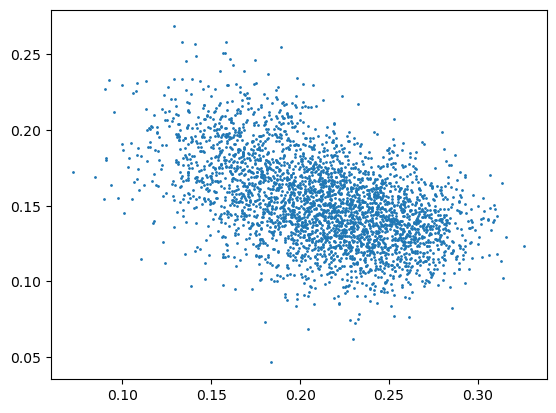

P14


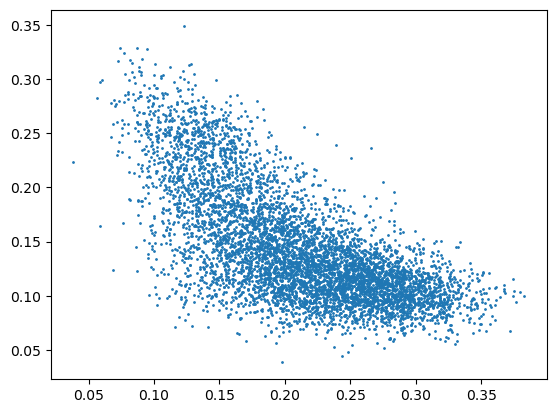

P17


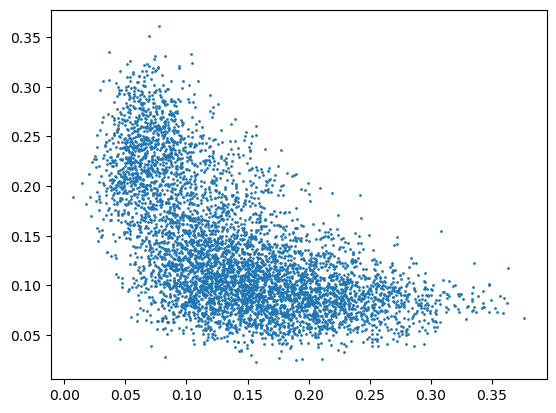

P21


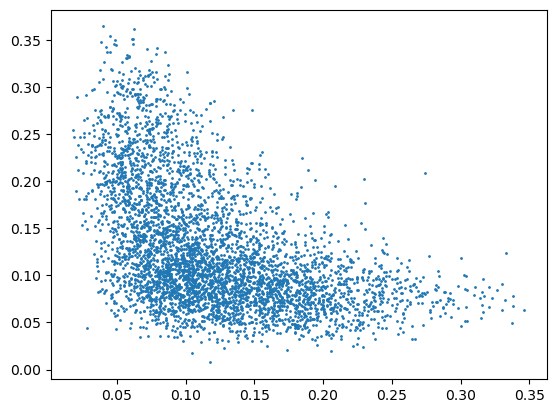

P28


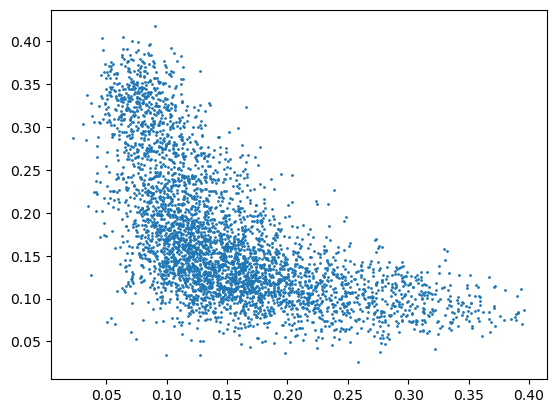

P28_dl


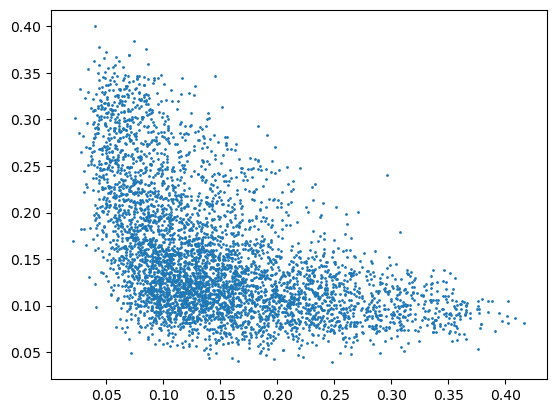

P28_dr


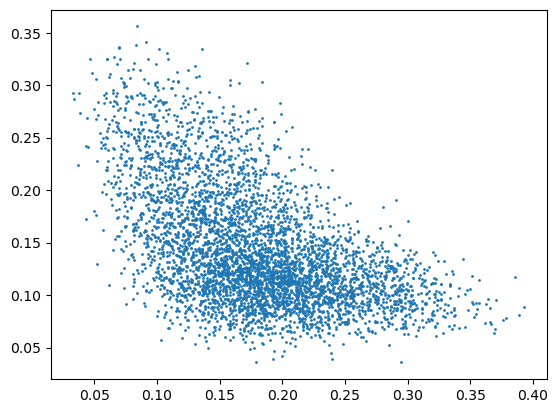

P38


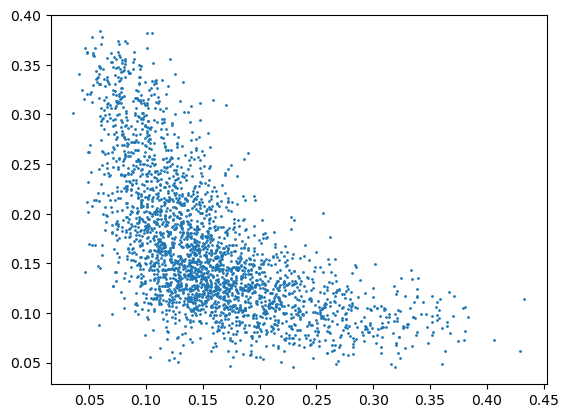

P38_dr


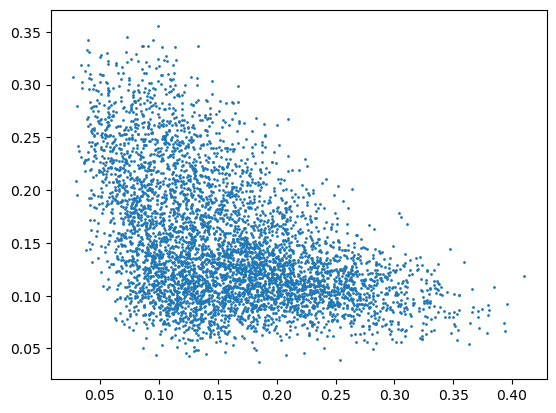

In [8]:
# min max for each gene for each condition 
res_all = []

for i, cond_name in enumerate(unq_conds):
    print(cond_name)
    adata = adata_all[adata_all.obs['Age']==cond_name]
    
    mat = adata.obsm['xln']

    mins = np.min(mat, axis=0)
    maxs = np.max(mat, axis=0)
    nmat = (mat - mins)/(maxs-mins+1e-10)

    scores_a = np.mean(nmat[:,agenes_idx], axis=1)
    scores_b = np.mean(nmat[:,bgenes_idx], axis=1)
    scores_c = np.mean(nmat[:,cgenes_idx], axis=1)
    
    res = pd.DataFrame(index=adata.obs.index.values)
    res['cond'] = cond_name
    res['scores_a'] = scores_a
    res['scores_b'] = scores_b
    res['scores_c'] = scores_c
    res_all.append(res)
    
    plt.scatter(scores_a, scores_c, s=1)
    plt.show()

In [9]:
print(fout)

/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/v1_multiome/scores_l23abc_cheng22_250904.csv


In [10]:
res_df = pd.concat(res_all)
res_df.to_csv(fout, header=True, index=True)

In [11]:
res_df

,cond,scores_a,scores_b,scores_c
CTGCTCACAGACAAGC-1-P8_2a-2022 RNA-1-0,P8,0.235065,0.123923,0.134322
GCGTGCAGTACCTTCC-1-P8_2b-2022 RNA-1-0,P8,0.150663,0.073564,0.141115
TCAATCTGTCTACAAC-1-P8_2b-2022 RNA-1-0,P8,0.155715,0.076085,0.162811
TGATCAGCACAAATCC-1-P8_2b-2022 RNA-1-0,P8,0.164145,0.112467,0.160589
TAACTTCTCCGCAAAT-1-P8_2a-2022 RNA-1-0,P8,0.245048,0.080301,0.143373
...,...,...,...,...
TTTCACACAGGTTTAC-1-P38_dr_2b-5,P38_dr,0.285434,0.066980,0.112412
TTTCACATCCTCGCAT-1-P38_dr_2b-5,P38_dr,0.158038,0.164603,0.105960
TTTCAGTAGATTCGAA-1-P38_dr_2b-5,P38_dr,0.149488,0.067582,0.235411
TTTCAGTGTTCAAGTC-1-P38_dr_2b-5,P38_dr,0.174859,0.126942,0.139796
